In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/test-titanic/test.csv


# Predicting Titanic Survivors Dataset with Logistic Regression

In [150]:
import matplotlib.pyplot as plt   
import copy
import math                       
import pandas as pd

%matplotlib inline

file_path = "/kaggle/input/titanic/train.csv"
df = pd.read_csv(file_path)

df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [151]:
print(df.columns)
print(df.head())

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0

**Selecting Age and Fare as inputs**

In [152]:
X_train = df.iloc[:, [4, 8]].values
y_train = df.iloc[:, 1].values 

In [153]:
print(np.unique(y_train))  # Should print: [0 1]

[0 1]


In [155]:
print("PassengerID:", X_train[:5])
print("Type of data:",type(X_train))

print("Survived:", y_train[:5])
print("Type of data:",type(y_train))

PassengerID: [['male' 'A/5 21171']
 ['female' 'PC 17599']
 ['female' 'STON/O2. 3101282']
 ['female' '113803']
 ['male' '373450']]
Type of data: <class 'numpy.ndarray'>
Survived: [0 1 1 1 0]
Type of data: <class 'numpy.ndarray'>


In [156]:
print("Number of positives:", np.sum(y_train == 1))
print("Number of negatives:", np.sum(y_train == 0))

Number of positives: 342
Number of negatives: 549


In [157]:
print(X_train.shape, y_train.shape)
print(np.unique(y_train))

(891, 2) (891,)
[0 1]


In [159]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (891, 2)
The shape of y_train is: (891,)
We have m = 891 training examples


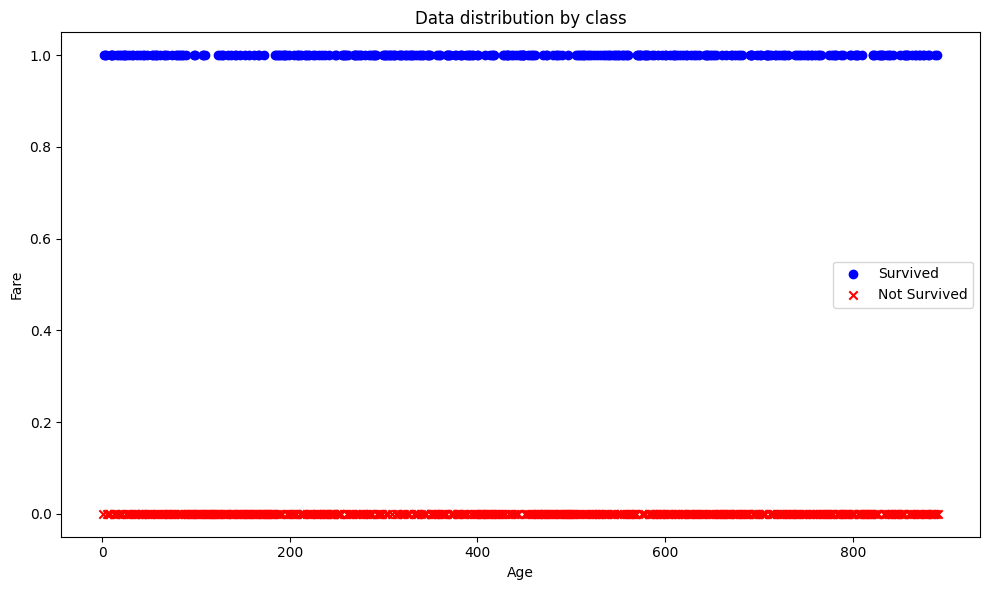

In [226]:
def plot_data_2D(X, y, pos_label="Survived", neg_label="Not Survived"):
    plt.figure(figsize=(10, 6))  # Increase figure size
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='b', label=pos_label, marker='o')
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='r', label=neg_label, marker='x')
    plt.xlabel('Age')
    plt.ylabel('Fare')  
    plt.legend()
    plt.title('Data distribution by class')
    plt.tight_layout() 
    plt.show()
plot_data_2D(X_train, y_train)

In [161]:
import numpy as np
X_train = df.iloc[:, :2].values
print("Original shape of data:", X_train.shape)

def map_feature(x1, x2, degree=6):
    out = [np.ones(x1.shape[0])]
    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((x1 ** (i - j)) * (x2 ** j))
    return np.stack(out, axis=1)

mapped_X = map_feature(X_train[:, 0], X_train[:, 1])
print("Shape after feature mapping:", mapped_X.shape)


Original shape of data: (891, 2)
Shape after feature mapping: (891, 28)


In [162]:
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", mapped_X[0])

X_train[0]: [1 0]
mapped X_train[0]: [1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0.]


In [173]:
#sigmoid function
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

In [239]:
#cost function regulized
def compute_cost_reg(X, y, w, b, lambda_):
    m = X.shape[0]
    z = X.dot(w) + b
    z = np.clip(z, -500, 500)
    h = 1 / (1 + np.exp(-z))
    
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)  # Clip predictions
    
    cost = (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    reg_cost = (lambda_ / (2 * m)) * np.sum(w ** 2)
    
    total_cost = cost + reg_cost
    return total_cost

In [184]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5
lambda_ = 0.5

cost = compute_cost_reg(X_mapped, y_train, initial_w, initial_b, lambda_)
print("Regularized cost:", cost)

Regularized cost: 21.245148145521174


In [185]:
#gradient function
def compute_gradient(X, y, w, b, *argv): 
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    z = np.dot(X, w) + b
    h = sigmoid(z)
    dj_db = np.sum(h - y) / m
    dj_dw = np.dot(X.T, h - y) / m        
    return dj_db, dj_dw

In [186]:
#gradient function regulized
def compute_gradient_reg(X, y, w, b, lambda_ = 1): 
    m, n = X.shape
    dj_db, dj_dw = compute_gradient(X, y, w, b)    
    dj_dw += (lambda_ / m) * w     
    return dj_db, dj_dw

In [187]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1) 
initial_w  = np.random.rand(X_mapped.shape[1]) - 0.5 
initial_b = 0.5
 
lambda_ = 0.5
dj_db, dj_dw = compute_gradient_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print(f"dj_db: {dj_db}", )
print(f"First few elements of regularized dj_dw:\n {dj_dw[:4].tolist()}", )

dj_db: 0.6157851855294073
First few elements of regularized dj_dw:
 [0.6157386209978151, 275.43409064259646, -0.00028051943051883045, 164905.4091647212]


In [188]:
#gradient descent
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    m = len(X)
    J_history = []
    w_history = []
    
    for i in range(num_iters):
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
        if i<100000:     
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history

In [189]:
np.random.seed(1)
initial_w = np.random.randn(X_mapped.shape[1]) * 0.01
initial_b = 0.0
lambda_ = 0.01    
iterations = 10000
alpha = 0.001
w,b, J_history,_ = gradient_descent(X_mapped, y_train, initial_w, initial_b, 
                                    compute_cost_reg, compute_gradient_reg, 
                                    alpha, iterations, lambda_)

Iteration    0: Cost 11595348228989303914496.00   
Iteration 1000: Cost 2972465385146288177152.00   
Iteration 2000: Cost 19930959221597948346368.00   
Iteration 3000: Cost 24230302755004767797248.00   
Iteration 4000: Cost 50165057252595794444288.00   
Iteration 5000: Cost 48930522082261801631744.00   
Iteration 6000: Cost 48929423755236832444416.00   
Iteration 7000: Cost 48928325456837526683648.00   
Iteration 8000: Cost 48927227184791343333376.00   
Iteration 9000: Cost 48926128938282020503552.00   
Iteration 9999: Cost 48925031815148631752704.00   


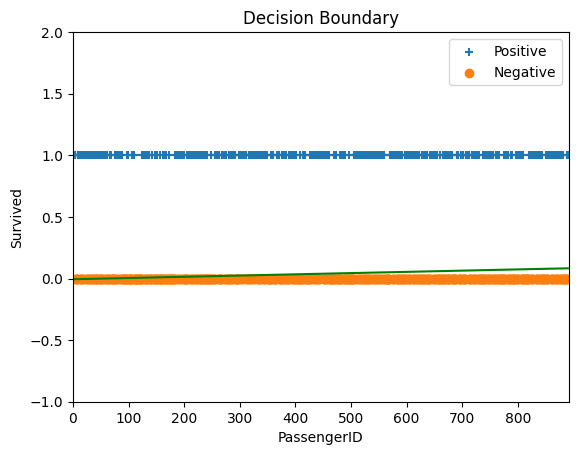

In [190]:
#decision boundary
def plot_decision_boundary(w, b, X, y, pos_label=1, neg_label=0):
    u = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200)
    v = np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200)
    z = np.zeros((len(u), len(v)))
    
    for i in range(len(u)):
        for j in range(len(v)):
            mapped_feature = map_feature(np.array([u[i]]), np.array([v[j]]))
            z[i,j] = (np.dot(mapped_feature, w) + b).item()
    
    z = z.T
    plt.contour(u, v, z, levels=[0], colors='g')
    plt.scatter(X[y==pos_label, 0], X[y==pos_label, 1], marker='+', label='Positive')
    plt.scatter(X[y==neg_label, 0], X[y==neg_label, 1], marker='o', label='Negative')
    plt.legend()
    plt.xlabel('PassengerID')
    plt.ylabel('Survived')
    plt.title('Decision Boundary')
    plt.show()
plot_decision_boundary(w, b, X_train[:, :2], y_train)

In [193]:
#prediction
def predict(X, w, b): 
    m, n = X.shape   
    p = np.zeros(m)
    for i in range(m):
        z_wb = np.dot(X[i], w) + b
        f_wb = sigmoid(z_wb)
        p[i] = 1 if f_wb >= 0.5 else 0
    return p

In [194]:
p = predict(X_mapped, w, b)

print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 96.408530


# Testing

In [195]:
file_path = "/kaggle/input/test-titanic/test.csv"
test_df = pd.read_csv(file_path)

test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [208]:
X_test = test_df.iloc[:, [4, 8]].values

In [209]:
print(X_test.shape)
print(w.shape)

(418, 2)
(28,)


In [212]:
print(w.shape)
w = w[:2]  

(28,)


In [214]:
z = np.dot(X_test, w) + b 

In [227]:
def sigmoid(x):
    x = np.clip(x, -500, 500) 
    return 1 / (1 + np.exp(-x))

In [232]:
def predict(X, w, b): 
    m, n = X.shape   
    p = np.zeros(m)
    for i in range(m):
        z_wb = np.dot(X[i], w) + b
        f_wb = sigmoid(z_wb)
        p[i] = 1 if f_wb >= 0.5 else 0
    return p

In [237]:
p_test = predict(X_test, w, b)
print(p_test)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [238]:
submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": p_test.astype(int) 
})

submission.to_csv("submission.csv", index=False)

print(submission.shape)

(418, 2)
